In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

from matplotlib.colors import ListedColormap

In [4]:
np.random.seed(42)

NAME = 'assignment4'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


# Ising Model

In [5]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 1
k = 0.5

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2))
grid_0[1:-1, 1:-1] = np.random.choice([-1, 1], (nx,nx))


def Ising_model(J):
    # Create grid
    grid = grid_0.copy()
    
    # Create list to store Magnetization modulus
    M = np.zeros(n_steps + 1)
    
    for step in range(n_steps):
        
        # Randomly choose lattice site 
        M[step:] += abs(np.sum(grid))
        i, j = np.random.randint(1, 41, 2)

        # Hamiltonian
        H = J*(grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1])
        
        # Probability
        P = np.exp(-H*2*grid[i, j])

        # Update grid
        if P > np.random.sample():
            grid[i, j] = -grid[i, j]

    # Create figures        
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( M/(np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    ax.grid(b=True, which='major', c='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('<|M|>')
    ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(grid[1:-1, 1:-1], cmap = 'hot')
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    

# Cellular Pots model

In [90]:
def kronecker_delta(i, j):
    return np.equal(i, j).astype(int)

def celltype_function(sigma, N_TYPES):
    return (np.mod(sigma, N_TYPES) + 1) * np.minimum(sigma + 1, 1)

def Cellular_Potts_model(
        J,                  # interaction strength matrix (NOTE: extra dimension for interaction with the fluid)
        A,                  # equilibrium areas (NOTE: fluid excluded, no extra dimension)
        n_MCS = 0,          # number of Monte Carlo steps
        T = 1,              # temperature
    ):

    N_CELLS = 120      # number of different cells (cell ids), can be nicely divided into 10 rows with 12 cells each
    N_TYPES = 2        # number of cell types (excluding fluid medium, which is denoted with -1)
    NX = 100           # size of the grid side
    K = 1              # "Boltzmann constant"
    LAM = 1            # lambda parameter

    assert J.shape == (N_TYPES + 1, N_TYPES + 1), f"Received: {J.shape}, Expected: {(N_TYPES + 1, N_TYPES + 1)}"
    assert A.shape == (N_TYPES + 1, )
    assert T > 0

    # Monte Carlo step as defined in the paper
    MCS = 16 * NX**2

    # Type-recognizing function
    celltype = lambda sigma : celltype_function(sigma, N_TYPES)

    # Create grid of cell ids with continuous boundaries, with cell types (except the fluid)
    # arranged in rectangles composing a larger square in the middle, with fluid around it
    # (see paper II.D3. Initial conditions)
    # NOTE: This is a hardcoded part working for this specific no. of cells and grid size
    grid = (-1) * np.ones((NX, NX), dtype=int)
    assign_order = np.random.permutation(N_CELLS)
    ysteps = np.linspace(25, 75, 11, dtype=int)

    for (i, y) in enumerate(ysteps[:-1]):
        xsteps = sorted(np.random.choice(range(26, 74), 11, replace=False))
        xsteps = np.insert(xsteps, 0, 25)
        xsteps = np.append(xsteps, 75)

        for (j, x) in enumerate(xsteps[:-1]):
            grid[y:ysteps[i+1], x:xsteps[j+1]] = assign_order[i*12 + j]

    # Store cell areas
    _, areas = np.unique(grid, return_counts=True)

    # Neighborhoods
    von_neumann_neighbourhood = np.array([[-1, 0], [0, -1], [0, 1], [1, 0]])
    moore_neighborhood = np.array([(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0)])
    
    for _ in range(n_MCS):
        for step in range(MCS):
            
            # Calculate magnetization
            # M[step:] += abs(np.sum(grid))

            # Randomly choose lattice site 
            i, j = np.random.randint(0, NX, 2)
            sigma = grid[i,j]
            tau = celltype(sigma)

            # Randomly choose a neighbour
            ip, jp = von_neumann_neighbourhood[np.random.randint(4)]
            iprime, jprime = (i + ip) % NX, (j + jp) % NX

            sigma_prime = grid[iprime, jprime]
            tau_prime = celltype(sigma_prime)

            # Change in volumetric energy
            a_sigma = areas[sigma]
            a_sigma_prime = areas[sigma_prime]

            A_sigma = A[tau]
            A_sigma_prime = A[tau_prime]

            delta_Hvol = -1
            if sigma == sigma_prime:
                delta_Hvol = 0
            elif (sigma != 0 and sigma_prime != 0):
                delta_Hvol = LAM * (((a_sigma - 1 - A_sigma)**2 + (a_sigma_prime + 1 - A_sigma_prime)**2) -
                                    ((a_sigma - A_sigma)**2 + (a_sigma_prime - A_sigma_prime)**2))
            elif (sigma == 0):
                delta_Hvol = LAM * ((a_sigma_prime + 1 - A_sigma_prime)**2 -
                                    (a_sigma_prime - A_sigma_prime)**2)
            elif (sigma_prime == 0):
                delta_Hvol = LAM * ((a_sigma - 1 - A_sigma)**2 -
                                    (a_sigma - A_sigma)**2)
            
            # Change in bond energy
            x = (i + moore_neighborhood[:,0]) % NX
            y = (j + moore_neighborhood[:,1]) % NX
            sum_prime = np.sum(J[tau_prime, celltype(grid[x, y])] * (1 - kronecker_delta(sigma_prime, grid[x, y])))
            sum_orig = np.sum(J[tau, celltype(grid[x, y])] * (1 - kronecker_delta(sigma, grid[x, y])))
            delta_Hbond = sum_prime - sum_orig
            
            # Total change
            H = delta_Hvol + delta_Hbond
            
            P = np.exp(-H/(K*T))

            # Update grid
            if H <= 0 or P > np.random.sample():
                grid[i, j] = grid[iprime, jprime]
                areas[sigma] -= 1
                areas[sigma_prime] += 1

    return grid

In [31]:
print(np.linspace(25, 75, 21, dtype=int))

[25 27 30 32 35 37 40 42 45 47 50 52 55 57 60 62 65 67 70 72 75]


In [138]:
def plot_cellular_potts(ax, grid, n_types, n_MCS):

    # Type-recognizing function
    celltype = lambda sigma : celltype_function(sigma, n_types)

    # Yeah it will only work for two cell types + surrounding fluid
    celltype_grid = celltype(grid)
    cmap = ListedColormap(['cyan', 'dimgray', 'gold'])
    ax.matshow(celltype_grid, cmap=cmap)

    # Draw cell boundaries
    for (i, _) in enumerate(grid):
        for (j, _) in enumerate(grid[i,:-1]):
            # Vertical checking
            if (i + 1 != grid.shape[0] and grid[i, j] != grid[i+1, j]):
                plt.plot([j-0.5, j+0.5], [i+0.5, i+0.5], c="black", lw=1.5)

            # Horizontal checking
            if (j + 1 != grid[0].shape[0] and grid[i, j] != grid[i, j+1]):
                plt.plot([j+0.5, j+0.5], [i-0.5, i+0.5], c="black", lw=1.5)

    # Set the title
    nsteps = 16 * n_MCS * grid.shape[0]**2
    ax.set_title('n = %i' % nsteps)

    # Turn off the axis
    # ax.axis('off')

In [47]:
# Properly declare parameters that actually can be passed to the function
#---------------------------------------

# Cell type equilibrium areas
A = np.zeros(3)

# Based on section II.B1. in the paper, adjusted to our grid size (100 x 100)
A[1] = 20
A[2] = 20

# Based on section III.A2. in the paper
J_MM = 0
J_ll = 10
J_dd = 8
J_ld = 6
J_lM = 12
J_dM = 12

T = 10
lam = 1

# 0: the surrounding fluid (M in the paper)
# 1: low surface energy 'dark' cells (d in the paper)
# 2: high surface energy 'light' cells (l in the paper)
J = np.array([
    [J_MM, J_dM, J_lM,],
    [J_dM, J_dd, J_ld,],
    [J_lM, J_ld, J_ll,],
])

# Other simulation parameters
n_MCS = 0
k = 1

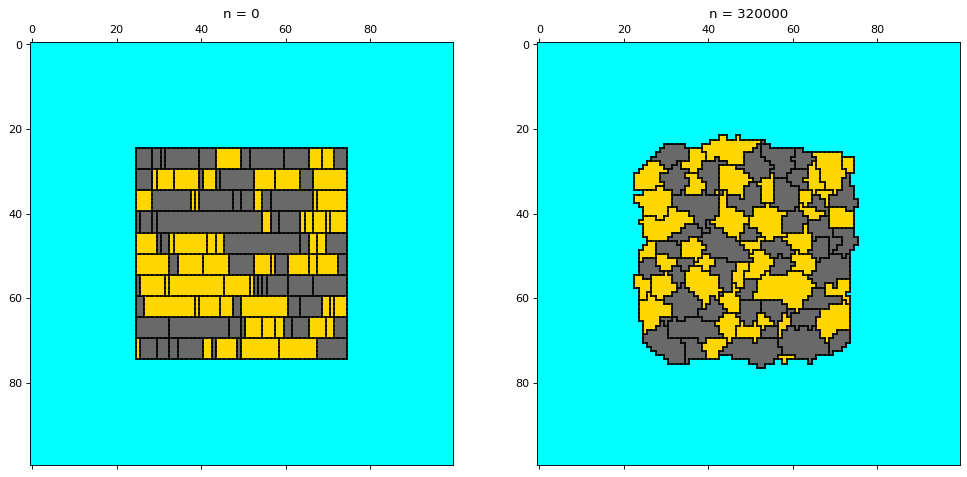

In [140]:
# Create figure        
fig = plt.figure(facecolor='w', figsize=(15,7.5), dpi=80)
fig.tight_layout()
ax = plt.subplot2grid((1, 2), (0, 0))
n_MCS = 0

# Simulate
cell_ids = Cellular_Potts_model(J, A, n_MCS, T)
plot_cellular_potts(ax, cell_ids, 2, n_MCS)

ax = plt.subplot2grid((1, 2), (0, 1))
n_MCS = 2

# Simulate
cell_ids = Cellular_Potts_model(J, A, n_MCS, T)
plot_cellular_potts(ax, cell_ids, 2, n_MCS)

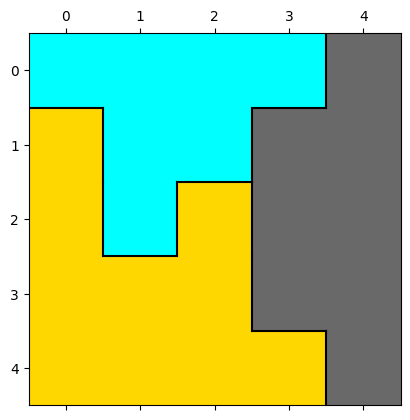

In [137]:
np.random.seed(42)

xx = np.array([
    [0, 0, 0, 0, 1], 
    [2, 0, 0, 1, 1], 
    [2, 0, 2, 1, 1], 
    [2, 2, 2, 1, 1], 
    [2, 2, 2, 2, 1], 
])

cmap = ListedColormap(['cyan', 'dimgray', 'gold'])
plt.matshow(xx, cmap=cmap)
# plt.axis('off')

NX = 5

for (i, y) in enumerate(xx):
    for (j, x) in enumerate(xx[i,:-1]):
        # Vertical checking
        if (i + 1 != xx.shape[0] and xx[i, j] != xx[i+1, j]):
            plt.plot([j-0.5, j+0.5], [i+0.5, i+0.5], c="black", lw=1.5)

        # Horizontal checking
        if (j + 1 != xx[0].shape[0] and xx[i, j] != xx[i, j+1]):
            plt.plot([j+0.5, j+0.5], [i-0.5, i+0.5], c="black", lw=1.5)

plt.show()